<a href="https://colab.research.google.com/github/ahlraf/ML-projects/blob/main/basic_text_classification_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
print(tf.__version__)

2.4.1


**Sentiment analysis**<br>
Trains a sentiment analysis model to classify movie reviews as +ve or -ve, based on text of review - binary classification. Uses the IMDb. Split int 25,000 reviews for training and 25,000 reviews for testing (balanced sets).

Download and explore the IMDb dataset:

In [13]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
data = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')
data_dir = os.path.join(os.path.dirname(data), 'aclImdb')

In [14]:
os.listdir(data_dir)

['imdbEr.txt', 'README', 'train', 'imdb.vocab', 'test']

In [15]:
train_dir = os.path.join(data_dir,'train')
os.listdir(train_dir)

['neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'urls_unsup.txt',
 'unsup',
 'pos']

In [16]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


**Load the dataset**: using text_dataset_from_directory utility. To prepare dataset for binary classification, need 2 folders on disk: class_a and class_b --> +ve and -ve reviews. <br>Removing additional folders before using this utility:

In [17]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Use text_dataset_from_directory utility to create labeled tf.data.Dataset .<br>Create 80:20 split of training data using validation_split:

In [18]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [19]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Review', text_batch.numpy()[i])
    print('Label', label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [20]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print('Label 1 corresponds to', raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Validation set:

In [21]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Test set:

In [22]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


### Prepare dataset for training
Standardize, tokenize, vectorize the data: using preprocessing.TextVectorization layer.<br><br>
Standardization = preprocessing the text (remove punctuation/ HTML elements - simplify dataset).<br>
Tokenization = splitting strings into tokens<br>
Vectorization = converting tokens into numbers so they can be fed into a neural network.<br><br>
HTML tags aren't removed by default standardizer in TextVectorization layer - write custom standardization function to remove the HTML.

To prevent train/test skew, preprocess data identically at train & test time - include TextVectorization layer inside model.

In [24]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

TextVectorization layer: use to standardize, tokenize, vectorize. Set output_mode to int to create unique integer indices for each token.
<br>
Using default split function + custom standardization function + define constants (explicit max sequence_length - layer pads/ truncates sequence accordingly).

In [25]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

Call adapt to fit the state of the preprocessing layer to the dataset - causes model to build an index of strings to integers.<br>

Use only training data when calling adapt (using test set leaks information).

In [26]:
# make text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [27]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [28]:
# retrieve batch of 32 reviews and labels from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0] 
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

Each token has been replaced by an integer. Can look up the token each string corresponds to by calling .get_vocabulary() on the layer.

In [29]:
print("1287 -->", vectorize_layer.get_vocabulary()[1287])
print("313 -->", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --> silent
313 --> night
Vocabulary size: 10000


Apply TextVectorization layer to train, validation, test dataset:

In [30]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configuring dataset for performance
.cache() --> keeps data in memory after it's loaded off disk; this ensures the dataset doesn't become a bottleneck while training. If dataset too large to fit into memory, this creates a permanent on-disk cache - more efficient that many small files.<br>
.prefetch() --> overlaps data preprocessing and model execution while training.

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create model

In [32]:
embedding_dim = 16

In [33]:
model = tf.keras.Sequential([
  layers.Embedding(max_features+1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Layers stacked sequentially to build classifier:
1. Embedding layer: takes integer encoded reviews and looks up embedding vector for each word-index. Vectors learned at model trains, add dimension to output array. Resulting dimensions = (batch, sequence, embedding).
2. GlobalAveragePooling1D layer: returns fixed length output vector for each example by averaging over sequence dimension - allows model to handle input of variable length.
3. Fixed-length output vector piped through fully-connected (Dense) layer with 16 hidden units.
4. Last layer densely connected with single output node.

### Loss function and optimizer
Binary classification problem, model outputs probability (single unit layer with sigmoid activation) - losses.BinaryCrossentropy loss function + Adam optimizer.

In [34]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
#from_logits=True ==> values of loss obtained by the model are not normalized

### Train model

In [36]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2190 - binary_accuracy: 0.9212 - val_loss: 0.2884 - val_binary_accuracy: 0.8804
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2081 - binary_accuracy: 0.9255 - val_loss: 0.2867 - val_binary_accuracy: 0.8818
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1975 - binary_accuracy: 0.9295 - val_loss: 0.2860 - val_binary_accuracy: 0.8828
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1867 - binary_accuracy: 0.9353 - val_loss: 0.2861 - val_binary_accuracy: 0.8822
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1786 - binary_accuracy: 0.9383 - val_loss: 0.2867 - val_binary_accuracy: 0.8838
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1691 - binary_accuracy: 0.9430 - val_loss: 0.2884 - val_binary_accuracy: 0.8840
Epoch 7/10
625/625 [==============================] - 4s 7ms/ste

### Evaluate model


In [37]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3343 - binary_accuracy: 0.8674
Loss:  0.33432722091674805
Accuracy:  0.8674399852752686


### Plot of accuracy and loss over time
model.fit(): return History object that contains dictionary with everything that during training

In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

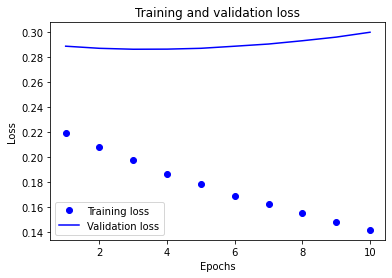

In [39]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

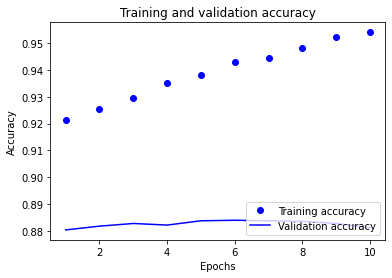

In [40]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Training accuracy increases, training loss decreases ==> expected, using gradient descent optimization.
<br>
Validation loss and accuracy seem to peak before training accuracy --> example of overfitting: model performs better on training data than on unseen data. Model over-optimizes and learns representations specific to training data that do not generalize.

Prevent overfitting by stopping training when validation accuracy is no longer increasing. Use tf.keras.callbacks.EarlyStopping.

### Export model
To make model capable of processing raw strings: include TextVectorization layer inside the model. Create a new model using weights trained:

In [41]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# test with raw_test_ds, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 13ms/step - loss: 0.3249 - accuracy: 0.8703
0.8674399852752686


### Inference on new data
Call model.predict()

In [42]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was bad..."
]

export_model.predict(examples)

array([[0.66702986],
       [0.417369  ],
       [0.36830717]], dtype=float32)

Including text preprocessing logic - enables to export model for production + reduces potential for train/test skew.

Outside mode --> allows asynchronous CPU processing + buffering when training on GPU
Include TextVectorization when ready to deploy.